In [8]:
!pip install nltk vaderSentiment requests alpha-vantage

# Fetch Tesla Stock Data from Alpha Vantage

In [9]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

# API key and TimeSeries initialization
api_key = '8PPCDLIGUNBC4QN6'
ts = TimeSeries(key=api_key, output_format='pandas')

# Define date range
start_date = "2025-02-15"
end_date = "2025-03-14"
print("Fetching stock data from", start_date, "to", end_date)

# Fetch and process daily data for TSLA
try:
    data, _ = ts.get_daily(symbol='TSLA', outputsize='full')
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()  # Ensure monotonic index before slicing
    stock_data = data.loc[start_date:end_date]
    stock_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    print("Stock data fetched successfully!")
    print("Number of rows fetched:", len(stock_data))
    print("\nFull TSLA Stock Data from", start_date, "to", end_date, ":\n")
    print(stock_data.to_string(index=True))
except Exception as e:
    print(f"Error fetching stock data: {e}")
    if 'data' in locals():
        print("Available date range:", data.index.min(), "to", data.index.max())

Fetching stock data from 2025-02-15 to 2025-03-14
Stock data fetched successfully!
Number of rows fetched: 19

Full TSLA Stock Data from 2025-02-15 to 2025-03-14 :

               Open      High       Low   Close       Volume
date                                                        
2025-02-18  355.010  359.1000  350.0200  354.11   51631702.0
2025-02-19  354.000  367.3400  353.6700  360.56   67094374.0
2025-02-20  361.510  362.3000  348.0000  354.40   45965354.0
2025-02-21  353.440  354.9800  334.4200  337.80   74058648.0
2025-02-24  338.140  342.3973  324.7000  330.53   76052321.0
2025-02-25  327.025  328.8900  297.2512  302.80  134228777.0
2025-02-26  303.715  309.0000  288.0400  290.80  100118276.0
2025-02-27  291.160  297.2300  280.8800  281.95  101748197.0
2025-02-28  279.500  293.8800  273.6000  292.98  115696968.0
2025-03-03  300.340  303.9400  277.3000  284.65  115551414.0
2025-03-04  270.930  284.3500  261.8401  272.04  126706623.0
2025-03-05  272.920  279.5500  267.7100  2

In [10]:
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2010-06-29,19.000,25.0000,17.54,23.89,18766300.0
2010-06-30,25.790,30.4192,23.30,23.83,17187100.0
2010-07-01,25.000,25.9200,20.27,21.96,8218800.0
2010-07-02,23.000,23.1000,18.71,19.20,5139800.0
2010-07-06,20.000,20.0000,15.83,16.11,6866900.0
...,...,...,...,...,...
2025-03-10,252.540,253.3700,220.00,222.15,185037825.0
2025-03-11,225.305,237.0649,217.02,230.58,174896415.0
2025-03-12,247.220,251.8400,241.10,248.09,142215681.0


# Fetch Tesla News from NewsAPI

In [11]:
import requests

# NewsAPI Key
news_api_key = 'a5ccb8033e2c484581672d6e182fc391'
start_date = "2025-02-15"
end_date = "2025-03-14"
print("Fetching news data from", start_date, "to", end_date)

# Fetch news data
url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'Tesla',
    'from': start_date,
    'to': end_date,
    'sortBy': 'relevancy',
    'apiKey': news_api_key,
    'pageSize': 100,
    'language': 'en'
}

try:
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] != 'ok':
        raise Exception(f"NewsAPI error: {data['message']}")
    articles = data['articles']
    news_data = pd.DataFrame(articles)[['publishedAt', 'title']]
    news_data.columns = ['date', 'headline']
    news_data['date'] = pd.to_datetime(news_data['date']).dt.tz_localize(None)
    news_data = news_data.sort_values('date')
    print("Number of news articles fetched:", len(news_data))
    print("\nFull News Data from", start_date, "to", end_date)
except Exception as e:
    print(f"Error fetching news data: {e}")

Fetching news data from 2025-02-15 to 2025-03-14
Number of news articles fetched: 96

Full News Data from 2025-02-15 to 2025-03-14


# Preprocess News Headlines and Sentiment Analysis

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Preprocess headlines
news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
news_data['sentiment_score'] = news_data['cleaned_headline'].apply(
    lambda text: analyzer.polarity_scores(text)['compound']
)

In [13]:
news_data

,date,headline,cleaned_headline,sentiment_score
33,2025-02-15 10:00:00,Tesla showrooms are being hit by a wave of ant...,tesla showrooms hit wave protests,-0.2263
14,2025-02-15 23:35:46,Americans protest Elon Musk: 'He should not be...,americans protest elon musk disassembling demo...,-0.2500
34,2025-02-16 11:33:01,Some of Trump's policy changes are expected to...,trump policy changes expected impact tesla elo...,-0.2960
83,2025-02-16 18:41:17,Elon’s Boring Company Is Planning to Build a 1...,elon boring company planning build tunnel duba...,-0.3182
24,2025-02-18 07:52:29,Almost a decade after Tesla first launched pre...,almost decade tesla first launched preorders c...,0.1280
...,...,...,...,...
78,2025-03-14 17:42:32,"Tesla, in a letter, tells Trump administration...",tesla letter tells trump administration worrie...,-0.2960
69,2025-03-14 18:30:41,Robotaxi Expert Suggests Elon Musk Will Try to...,robotaxi expert suggests elon musk try fake cy...,-0.4767
48,2025-03-14 20:07:00,Ex-astronaut Mark Kelly debuted his Chevy SUV ...,mark kelly debuted chevy suv dumping tesla,-0.3182
29,2025-03-14 21:04:25,A veteran Tesla engineering manager has joined...,veteran tesla engineering manager joined doge ...,0.0000


# Merge Data and Visualize

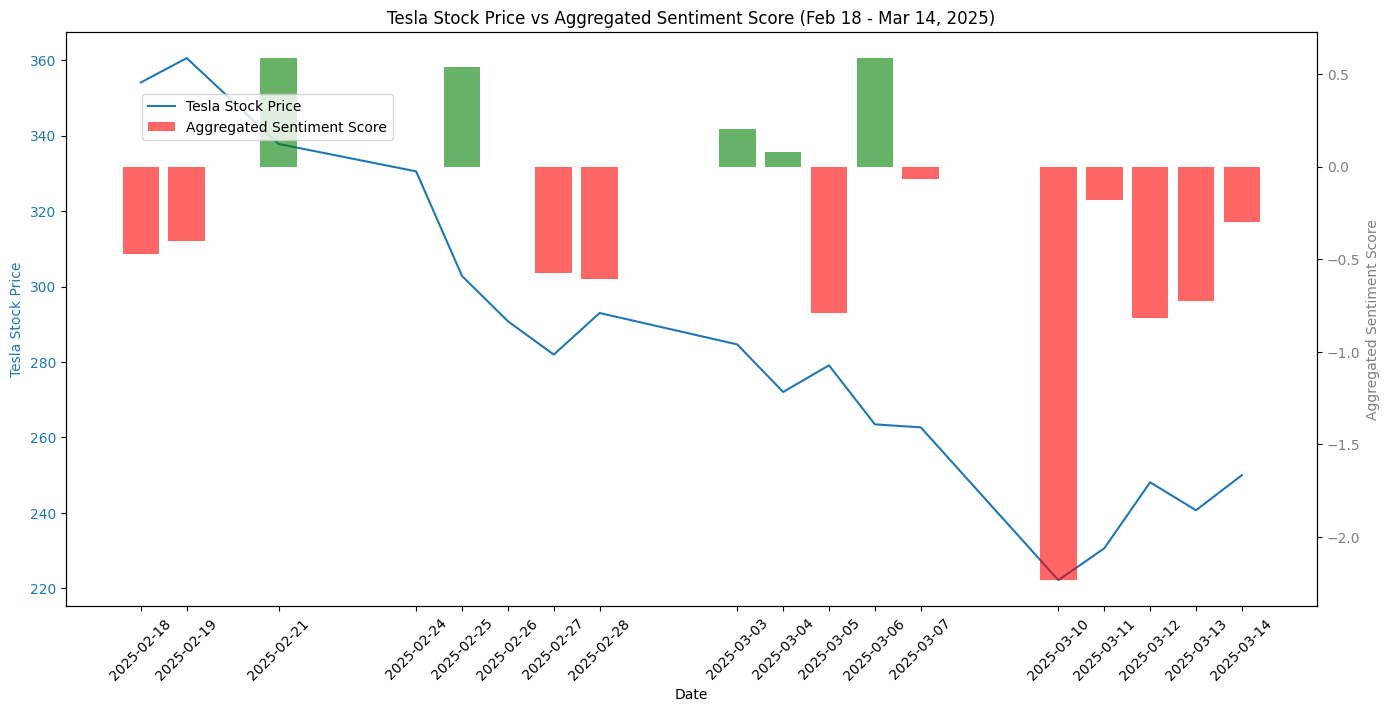


Combined Stock and Sentiment Data:

      date    Open     High      Low  Close      Volume  sentiment_score
2025-02-18 355.010 359.1000 350.0200 354.11  51631702.0          -0.4714
2025-02-19 354.000 367.3400 353.6700 360.56  67094374.0          -0.4019
2025-02-21 353.440 354.9800 334.4200 337.80  74058648.0           0.5853
2025-02-24 338.140 342.3973 324.7000 330.53  76052321.0           0.0000
2025-02-25 327.025 328.8900 297.2512 302.80 134228777.0           0.5364
2025-02-26 303.715 309.0000 288.0400 290.80 100118276.0           0.0000
2025-02-27 291.160 297.2300 280.8800 281.95 101748197.0          -0.5719
2025-02-28 279.500 293.8800 273.6000 292.98 115696968.0          -0.6058
2025-03-03 300.340 303.9400 277.3000 284.65 115551414.0           0.2023
2025-03-04 270.930 284.3500 261.8401 272.04 126706623.0           0.0815
2025-03-05 272.920 279.5500 267.7100 279.10  94042913.0          -0.7923
2025-03-06 272.060 272.6500 260.0200 263.45  98451566.0           0.5859
2025-03-07 259

In [14]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Convert dates to date-only format for merging
news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data = stock_data.reset_index()
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

# Aggregate sentiment scores by date
aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()

# Merge stock and sentiment data
combined_data = pd.merge(stock_data, aggregated_sentiment, on='date', how='inner')

# Visualize
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(combined_data['date'], combined_data['Close'], label='Tesla Stock Price', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Stock Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(combined_data['date'])
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data['date'], combined_data['sentiment_score'], label='Aggregated Sentiment Score', color=colors, alpha=0.6)
ax2.set_ylabel('Aggregated Sentiment Score', color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

fig.tight_layout()
plt.title('Tesla Stock Price vs Aggregated Sentiment Score (Feb 18 - Mar 14, 2025)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# Print combined data
print("\nCombined Stock and Sentiment Data:\n")
print(combined_data.to_string(index=False))